In [16]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

Conditioned on the mode sequence, one may partition the observations into K different linear regression problems, where $K = \vert \{ z_1, \dots, z_T \} \vert$. So for each model $k$, we form a matrix $Y^{(k)}$, with $N_k$ columns consisting of the observations $y_t$ with $z_t = k$. Then, 
$$
Y^{(k)} = A^{(k)}\bar{Y}^{(k)} + E^{(k)}
$$
where $A^{(k)} = [A^{(k)}_1 \dots A^{(k)}_r$, $\bar{Y}^{(k)}$ is a matrix of lagged  observations and E is the associated noise vectors.

In [17]:
A = np.array([[1,2],[3,4]])
B = np.array([[1,0,4],[0,4,0],[1,1,1]])
np.kron(A,B)

array([[ 1,  0,  4,  2,  0,  8],
       [ 0,  4,  0,  0,  8,  0],
       [ 1,  1,  1,  2,  2,  2],
       [ 3,  0, 12,  4,  0, 16],
       [ 0, 12,  0,  0, 16,  0],
       [ 3,  3,  3,  4,  4,  4]])

# Use Gharamani-Hinton as first test

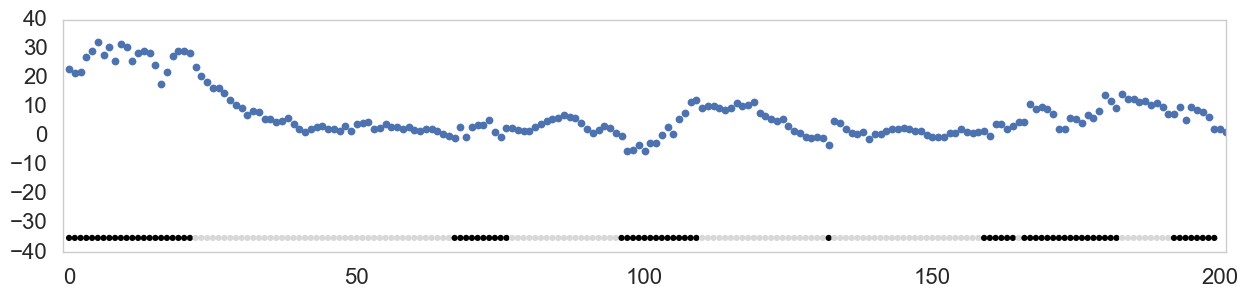

In [18]:
x1 = lambda x: 0.99*x + np.random.normal(0,np.sqrt(10))
x2 = lambda x: 0.9*x + np.random.normal(0,np.sqrt(1))
X = [x1, x2]

def generate_chain():
    ys = [np.random.normal(20,5)]
    
    chains = []
    chain = np.random.choice([0,1], p=[0.5,0.5])
    chains.append(chain)
    
    ys.append(X[chain](ys[-1]))

    for i in range(200):
        if np.random.uniform(0,1) < 0.05:
            if chain == 0:
                chain = 1
            else:
                chain = 0
        chains.append(chain)
        
        ys.append(X[chain](ys[-1]))
    return (np.array(chains), np.array(ys))

chains, ys = generate_chain()

fig, ax = plt.subplots(figsize=(15,3))
temp = np.arange(0,200,1)

c=['black','#d8d8d8']

plt.scatter(temp, -35*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(ys, lw=0, marker='.')
plt.xlim([-1,201])
plt.grid(False)

# Successively test each of the steps for the HDP-AR model

In [19]:
import hdp_scripts as hdp
import classification_evaluation as hdp_eval
import imp # for reloading a local script
import time
imp.reload(hdp)
imp.reload(hdp_eval)

<module 'classification_evaluation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/classification_evaluation.py'>

In [20]:
params = {}

# define L=15 components:
L = 15
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = ys
params['T'] = len(ys)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 100
params['gamma'] = 1
params['priors'] = {
    'M': 1*np.eye(D),
    'K': 5e-1*np.eye(D)
}

In [21]:
num_iter = 40
z = np.zeros_like(ys)
hamming_dists = []
assignments = np.zeros(shape=(len(z), num_iter))

for i in range(num_iter):
    start = time.time()
    params, res = hdp.sticky_HDP_AR(ys, params, priors=[1*np.eye(1), 10])
    seq2_updated, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res[1:])
    hamming_dists.append(hamming_val)
    z = res
    assignments[:,i] = np.array(z, dtype=np.int16)
    if i % 10 == 0:
        print("Iteration: %i, time: %0.2f, hamming_dist: %0.3f"%(i, time.time() - start, hamming_val))

Iteration: 0, time: 0.74, hamming_dist: 164.000
Iteration: 10, time: 0.74, hamming_dist: 20.000
Iteration: 20, time: 0.71, hamming_dist: 18.000
Iteration: 30, time: 0.67, hamming_dist: 13.000


In [22]:
params['theta']

[{'A': array([[0.99771622]]), 'sigma': array([[0.12088848]])},
 {'A': array([[1.25566371]]), 'sigma': array([[0.11098609]])},
 {'A': array([[1.35042798]]), 'sigma': array([[0.14715702]])},
 {'A': array([[0.69949291]]), 'sigma': array([[0.141664]])},
 {'A': array([[0.9902769]]), 'sigma': array([[9.41901241]])},
 {'A': array([[0.66895984]]), 'sigma': array([[0.12361522]])},
 {'A': array([[0.91617677]]), 'sigma': array([[1.20231822]])},
 {'A': array([[0.97871618]]), 'sigma': array([[0.11370644]])},
 {'A': array([[1.35627124]]), 'sigma': array([[0.11561931]])},
 {'A': array([[0.97156504]]), 'sigma': array([[0.1096156]])},
 {'A': array([[1.12941794]]), 'sigma': array([[0.11946147]])},
 {'A': array([[0.86126529]]), 'sigma': array([[0.12012471]])},
 {'A': array([[1.00047074]]), 'sigma': array([[0.13821828]])},
 {'A': array([[0.96888197]]), 'sigma': array([[0.10201589]])},
 {'A': array([[1.06094939]]), 'sigma': array([[0.17603967]])}]

In [23]:
res = np.median(assignments[:,assignments.shape[1]*3//4:], axis=1).astype(np.int16)[1:]
res

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4,
       4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4], dtype=int16)

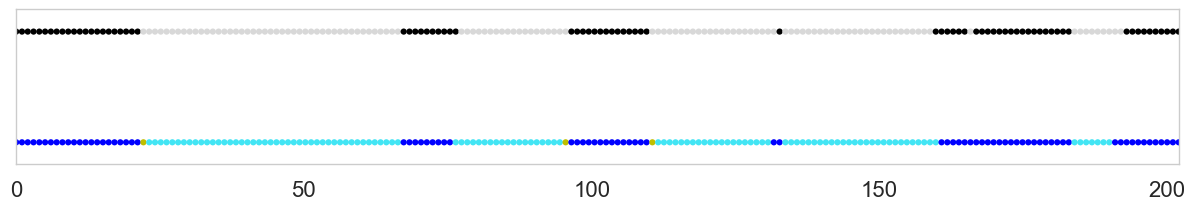

In [24]:
# plt.scatter(np.linspace(0,len(z),num=len(z)), 1*np.ones_like(z), c=[c[i] for i in fwd_pass['z']], lw=0)
# plt.scatter(np.linspace(0,len(z),num=len(z)), 1.25*np.ones_like(z), c=[c[i] for i in np.argmax(back_messages, axis=1)], lw=0)
c=['black','#d8d8d8', 'r', 'g', 'b', 'y', '#42e5f4', '#42e5f4', '#f47a41', 'blue',
  '#597757', '#576977', '#635777', '#635777', '#0FF000']

plt.figure(figsize=(15,2))
plt.scatter(np.linspace(0,len(z),num=len(z)), 1.5*np.ones_like(z), c=[c[i] for i in res], lw=0)
plt.xlim([0,len(z)])
plt.scatter(np.linspace(0,len(z),num=len(z)), 2*np.ones_like(z), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(z)])

plt.yticks([])
plt.grid(False)

## Now try something more akin to Connected Worlds:

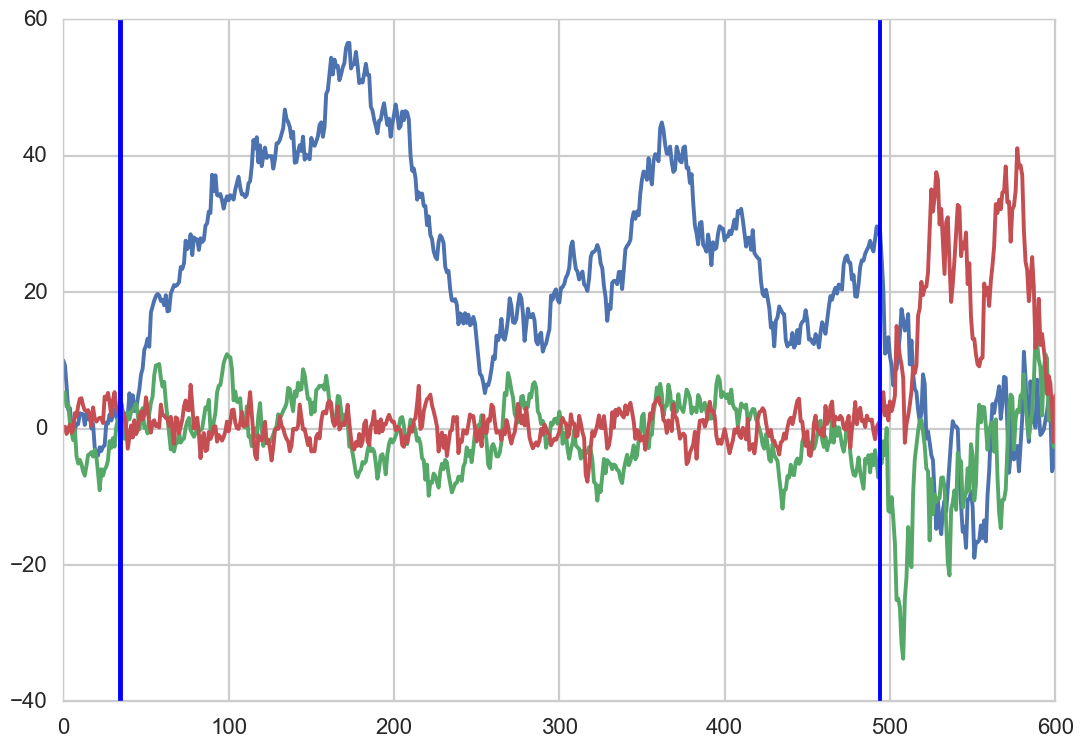

In [163]:
Y = np.array([10,5,0]) # there are three observables
dim = 3
waterfall=np.zeros(shape=(dim,dim))
waterfall[0,0]=1
def generateTransitionMatrix(dim):
    A = np.random.beta(10,1,size=dim) * np.eye(dim)
#     A = np.random.dirichlet(np.ones(dim), size=3).T + 40*np.eye(dim) #+ 40*waterfall
#     A = A/(A.sum(axis=0)+1)
    return A

A = generateTransitionMatrix(dim)
chain = 0

Ys = [Y]
expected_val = [Y]
As = [A]
chains = [chain]
switch = []
noise_lvl = np.random.gamma(1,5)
noise_lvls = [noise_lvl]

for i in range(600):
    
    if np.random.uniform(0,1) < 0.005:
        chain += 1
        A = generateTransitionMatrix(dim)
        As.append(A)
        switch.append(i)
        expected_val[-1] = Ys[-1]
        noise_lvl = np.random.gamma(1,5)
        noise_lvls.append(noise_lvl)
    
    noise = np.zeros(shape=dim)
#     noise[:-1] = np.random.normal(0,5,size=(dim-1))
#     noise[-1] = -np.sum(noise[:-1])
    noise = np.random.multivariate_normal([0,0,0],noise_lvl*np.array([[1,0,0],[0,1,0],[0,0,1]]))
    
    next_obs = As[-1].dot(Ys[-1]) + noise
#     next_obs = next_obs/np.sum(next_obs)
    
    expected_val.append(As[-1].dot(expected_val[-1]))
    
    Ys.append(next_obs)
    chains.append(chain)
    
    
plt.plot(Ys)
# plt.plot(expected_val)
[plt.axvline(s) for s in switch]
plt.show()

In [164]:
noise_lvls

[2.612329441935781, 8.660055338319303, 2.7867011256860685, 16.457393317299392]

In [165]:
np.random.gamma(1,5)

2.523496083016679

In [166]:
imp.reload(hdp)
imp.reload(hdp_eval)

params = {}

# define L=15 components:
L = 5
D = 3 # dimensionality of the data

Y = Ys
Y_bar = np.zeros_like(Y)
Y_bar[0] = Y[0]
Y_bar[1:] = Y[0:-1]
mu = np.dot(np.linalg.pinv(Y_bar), Y)

params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
# params['theta'] = [{'A': mu, 'sigma': 1e-1*np.eye(D)} for i in range(L)]
params['theta'] = [{'A': np.eye(D), 'sigma': 1*np.eye(D)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 100
params['gamma'] = 1
params['priors'] = {
    'M': np.eye(D),
    'K': 1*np.eye(D)
}
std = np.std(Y - Y_bar.dot(mu))
std

2.291631525081817

In [169]:
num_iter = 40
z = np.zeros_like(Y)
hamming_dists = []
assignments = np.zeros(shape=(len(z), num_iter))

for i in range(num_iter):
    start = time.time()
    params, res = hdp.sticky_Multi_HDP_AR(Y, params, priors=[1*np.eye(D), 1e1])
    seq2_updated, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)
    hamming_dists.append(hamming_val)
    z = res
    assignments[:,i] = np.array(z, dtype=np.int16)
    if i % 10 == 0:
        print("Iteration: %i, time: %0.2f, hamming_dist: %0.3f"%(i, time.time() - start, hamming_val))

Iteration: 0, time: 0.82, hamming_dist: 99.000
Iteration: 10, time: 0.79, hamming_dist: 79.000
Iteration: 20, time: 0.79, hamming_dist: 65.000
Iteration: 30, time: 0.79, hamming_dist: 56.000


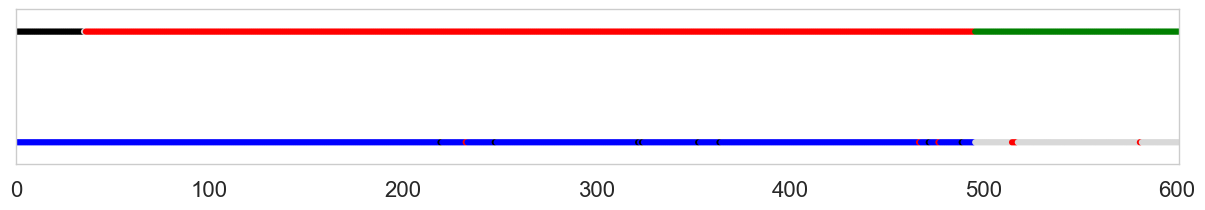

In [170]:
c=['black','#d8d8d8', 'r', 'g', 'b', 'y', '#42e5f4', '#42e5f4', '#f47a41', 'blue',
  '#597757', '#576977', '#635777', '#635777', '#635777']
plt.figure(figsize=(15,2))
plt.scatter(np.linspace(0,len(z),num=len(z)), 1.5*np.ones_like(z), c=[c[i] for i in res], lw=0)
plt.scatter(np.linspace(0,len(z),num=len(z)), 2*np.ones_like(z), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(z)])

plt.yticks([])
plt.grid(False)

In [124]:
params['theta']

[{'A': array([[ 0.91345371,  0.00948132,  0.02614392],
         [-0.12456372,  1.35524906, -0.0961212 ],
         [ 0.07510102,  0.19391419,  0.98598081]]),
  'sigma': array([[ 0.13928493, -0.00175049,  0.0005888 ],
         [-0.00175049,  0.21425226, -0.01146161],
         [ 0.0005888 , -0.01146161,  0.14815448]])},
 {'A': array([[ 0.75524321,  0.21959875, -0.02982853],
         [-0.0017072 ,  0.66586716, -0.20151407],
         [-0.06241534,  0.22876326,  0.79360477]]),
  'sigma': array([[ 0.148926  , -0.01227425,  0.00341776],
         [-0.01227425,  0.20453673,  0.01982915],
         [ 0.00341776,  0.01982915,  0.14861867]])},
 {'A': array([[ 0.99345115, -0.07329224, -0.0125131 ],
         [-0.04501635,  0.97878207,  0.09858216],
         [ 0.0186126 , -0.10792025,  1.0098556 ]]),
  'sigma': array([[ 0.37489827,  0.16465297,  0.16381607],
         [ 0.16465297,  1.23183232, -0.07561184],
         [ 0.16381607, -0.07561184,  0.17870206]])},
 {'A': array([[ 0.85653408, -0.19176064,  0

Given the observation sequence Ys lets just try learn one transition matrix that describes the observations. With a Gibbs sampler defined in the paper.

In [72]:
# set the priors
D = 3
L = D
mu_0 = np.eye(D)
sig_0 = np.eye(D)
nu_0 = 10
sig_0_inv = np.linalg.pinv(sig_0)

eta = 10
Psi_0 = np.eye(3)

Y = np.array(Ys[55:100])
n = len(Y)
Y_bar = np.zeros_like(Y)
Y_bar[0] = Y[0]
Y_bar[1:] = Y[0:-1]

# Y = Y.T
# Y_bar = Y_bar.T

thetas = []
theta = {"A": 1*np.eye(D), "Sigma": np.eye(3)}

M = np.eye(D)
K = 1*np.eye(D)

Sigmas = np.zeros(shape=(100,D,D))
mus = np.zeros(shape=(100,D,D))

for i in range(100):
    
    X = Y_bar
    sig_inv = np.linalg.pinv(theta['Sigma'])
    Sigma = np.linalg.pinv(sig_0_inv + n*sig_inv)
    
    sample_mean = np.dot(np.linalg.pinv(Y_bar), Y)
    A = np.zeros_like(theta['A'])
    # try with just one row of the update matrix
    for l in range(L):
        mu = Sigma.dot(sig_0_inv.dot(mu_0[l,:]) + n*sig_inv.dot(sample_mean[l,:]))
        A[l,:] = np.random.multivariate_normal(mu, Sigma)
        
    nu = n + nu_0
    Y_YbarA = Y - Y_bar.dot(A)
    Psi = Psi_0 + (Y_YbarA.T).dot(Y_YbarA)
    Sigma = stats.invwishart(scale=Psi, df=nu).rvs()
    
    Sigmas[i] = Sigma
    mus[i] = A
    
    theta['A'] = A
    theta['Sigma'] = Sigma
    
    thetas.append(copy.deepcopy(theta))

In [73]:
(Y_YbarA.T).dot(Y_YbarA) + 1e-5*np.eye(D)

array([[ 0.00298959, -0.01141343, -0.00675851],
       [-0.01141343,  0.04743438,  0.02779199],
       [-0.00675851,  0.02779199,  0.01672715]])

In [74]:
A = np.mean([t['A'] for t in thetas[75:]], axis=0)
Sigma = np.mean([t['Sigma'] for t in thetas[75:]], axis=0)

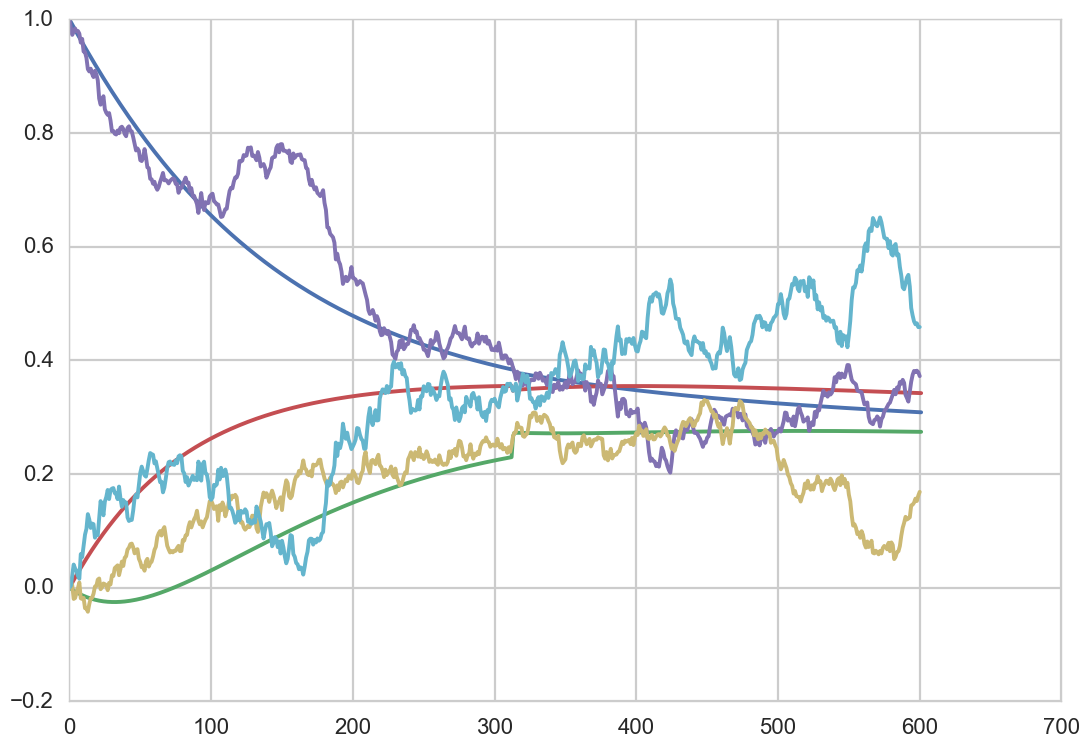

In [103]:
pred_y = [np.array([1,0,0])]
for i in range(len(Ys)):
    if i > 0:
        if res[i] != res[i-1]:
            pred_y[-1] = Ys[i]
    pred_y.append(params['theta'][res[i]]['A'].dot(pred_y[-1]))
#     pred_y.append(pred_y[-1].dot(theta['A']))
#     pred_y.append(pred_y[-1].dot(thetas[-1]['A']))
    
plt.plot(pred_y)
plt.plot(Ys)

In [65]:
np.kron()
np.vectorize()

-2.3378770664093453

In [66]:
stats.multivariate_normal([0,0],np.eye(2)allow_singular=True).logpdf([0,1])
stats.multivariate_normal()

-2.3378770664093453

In [ ]:
stats.matrix_normal()